# Python - Loading and plotting ADCP data


**Aim:** To load and plot ADCP data from a `*.txt` file ('ascii_template_20230511_002_ASC_Analyse.TXT'), one day's worth of ADCP data from the Seepraktikum in 2023.

**Data:** Download the data files from last year's data repository.

**Directions:** Create an `*.ipynb` and 2 figures: the sections of velocity.

**Based on:** [read-raw-data.py](read-raw-data.py) from Yves Sorge.


<hr>

## Package requirement: adcpreader

You will need adcpreader: https://pypi.org/project/adcpreader/ installed within your environment

In [14]:
# Your code here
import pandas as pd
import numpy as np
import xarray as xr
from datetime import datetime
import scipy.io as sio
from datetime import date
from read_ascii_data import *
import os
import glob


# If this fails, then please see the installation instructions above.
import adcpreader


# Plotting
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

import palettable.colorbrewer.sequential as cbseq

from palettable.colorbrewer.sequential import Blues_8
from palettable.cartocolors.sequential import Sunset_7_r
from palettable.cartocolors.sequential import BluYl_7


In [15]:
# File paths
file_path = '/Users/eddifying/Dropbox/data/SeePrakt-data/2023-seepraktikum/adcp-data/raw/'
filename = 'WR2_AUTO_600KHZ_0_002_001_23-05-11_062752.PD0'

In [30]:
# Define reader, sink, info
reader = adcpreader.rdi_reader.PD0()
sink = adcpreader.rdi_writer.DataStructure()
info = adcpreader.rdi_writer.Info(pause=False)

# Define processing pipeline
pipeline = reader | info | sink

# set full path filename
fname = file_path + filename

# Process the pipeline
pipeline.process(fname)

# Accessing the available keys
print("Keys:")
print(sink.keys())
print("")

# Get NaN value (assume, that last entry of ensemble 1 is NaN - TODO fix this)
nan_value = sink.data['velocity_starboard'][0][-1]

ADCP configuration 
--------------------------------------------------------------------------------
CPU_ver              : 51
CPU_rev              : 40
Sys_Freq             : 600 kHz
Beam_Pattern         : Convex
Sensor_Cfg           : Sensor Cfg #1
Xdcr_Head            : Xdxr Head attached
Xdcr_Facing          : Down
Beam_Angle           : 20 Degree
Beam_Cfg             : 4 Beam Janus
Real_Data            : True
N_Beams              : 4
N_Cells              : 141
N_PingsPerEns        : 2
DepthCellSize        : 0.5
Blank                : 0.25
WaterMode            : 1
CorrThresshold       : 64
Code_Repts           : 5
MinPG                : 0
ErrVelThreshold      : 1.5
TimeBetweenPings     : 00:00.20
RawCoordXrfm         : 23
CoordXfrm            : Ship
CoordXfrmOptions     : Bin Mapping|3 Beam|Tilts
Vel_field1           : To Stbd
Vel_field2           : To Aft
Vel_field3           : Up
Vel_field4           : Error
EA                   : 11.0
EB                   : 0.0
Sensors          

In [32]:
# Create a list of file
file_list = glob.glob(file_path+ "*.PD0")
#pipeline.process(file_list)


In [56]:
# Extracting data for velocity transformation
velocity_starboard = np.array(sink.data['velocity_starboard'])
velocity_forward = np.array(sink.data['velocity_forward'])
velocity_up = np.array(sink.data['velocity_up'])


time = np.array(sink.data['Time'])
range1 = np.array(sink.data['r'])
fnames = ['velocity_starboard','velocity_forward','velocity_up',
          'correlation_Corr1','correlation_Corr2','correlation_Corr3','correlation_Corr4','correlation_Corr_AVG',
          'echo_Echo1','echo_Echo2','echo_Echo3','echo_Echo4','echo_Echo_AVG',
          'percent_good_PG1','percent_good_PG2','percent_good_PG3','percent_good_PG4']

qdo=0
for ff in fnames:
    da = xr.DataArray(data = np.array(sink.data[ff]),
                      dims = ["time","range1"],
                      coords = dict(time=time,range1=range1.T))

    
    if qdo==0:
        da_all = da.to_dataset(name=ff)
        qdo=qdo+1
    else:
        da1 = da.to_dataset(name=ff)
        da_all = xr.merge([da_all,da1])


fnames=['Ensnum','Soundspeed','Depth','Heading','Pitch','Roll','Salinity','Temperature',
        'bottom_track_starboard','bottom_track_forward','bottom_track_up','bottom_track_error',
        'bottom_track_PG1','bottom_track_PG2','bottom_track_PG3','bottom_track_PG4',
        'bottom_track_Range1','bottom_track_Range2','bottom_track_Range3','bottom_track_Range4']


for ff in fnames:
    da = xr.DataArray(data = np.array(sink.data[ff]),
                      dims = ["time"],
                      coords = dict(time=time))
    
    da1 = da.to_dataset(name=ff)
    da_all = xr.merge([da_all,da1])

['Minimim "time" difference1.0679998397827148']


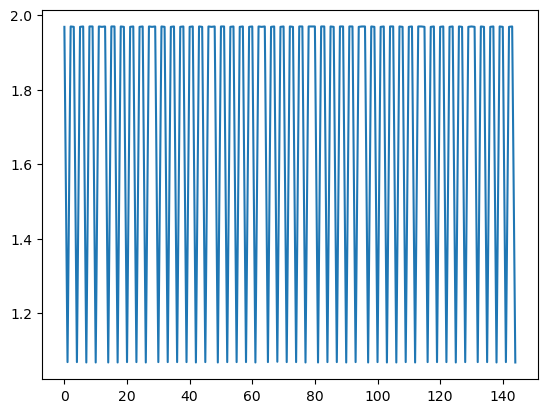

In [65]:
plt.plot(np.diff(da_all.time))
print('Minimum "time" difference ' + str(np.diff(da_all.time).min()))

print('Maximum "time" difference ' + str(np.diff(da_all.time).min()))


In [7]:
# Extracting data for velocity transformation
velocity_starboard = np.array(sink.data['velocity_starboard'])
velocity_forward = np.array(sink.data['velocity_forward'])
velocity_up = np.array(sink.data['velocity_up'])

heading = np.array(sink.data['Heading'])
pitch = np.array(sink.data['Pitch'])
roll = np.array(sink.data['Roll'])

# Set NaN values to NaN
velocity_starboard = np.where(velocity_starboard == nan_value, np.nan, velocity_starboard)
velocity_forward = np.where(velocity_forward == nan_value, np.nan, velocity_forward)
velocity_up = np.where(velocity_up == nan_value, np.nan, velocity_up)

# Assuming heading, pitch, and roll are in degrees, convert to radians
heading_rad = np.deg2rad(heading)
pitch_rad = np.deg2rad(pitch)
roll_rad = np.deg2rad(roll)

# Transformation from instrument to earth coordinates
def transform_to_earth(vel_starboard, vel_forward, vel_up, heading, pitch, roll):
    # Rotation matrix for heading
    R_heading = np.array([
        [np.cos(heading), -np.sin(heading), 0],
        [np.sin(heading), np.cos(heading), 0],
        [0, 0, 1]
    ])
    
    # Combine the velocities
    velocity_instr = np.array([vel_starboard, vel_forward, vel_up])
    
    # Transform velocities
    velocity_earth = np.dot(R_heading, velocity_instr)
    
    return velocity_earth

# Calculate east and north velocities for each ensemble
east_velocity = []
north_velocity = []
up_velocity = []

for i in range(len(velocity_starboard)):
    vel_earth = transform_to_earth(
        velocity_starboard[i],
        velocity_forward[i],
        velocity_up[i],
        heading_rad[i],
        pitch_rad[i],
        roll_rad[i]
    )
    east_velocity.append(vel_earth[0])
    north_velocity.append(vel_earth[1])
    up_velocity.append(vel_earth[2])

# Convert to numpy arrays
east_velocity = np.array(east_velocity)
north_velocity = np.array(north_velocity)
up_velocity = np.array(up_velocity)

# Convert to numpy arrays
east_velocity = np.array(east_velocity)
north_velocity = np.array(north_velocity)
up_velocity = np.array(up_velocity)


# Print velocity data for ensemble 1
print("East Velocity for first ensemble:\n", east_velocity[0])
print("North Velocity for first ensemble:\n", north_velocity[0])
print("Up Velocity for first ensemble:\n", up_velocity[0])

# Calculate the magnitude
magnitude = np.sqrt(east_velocity**2 + north_velocity**2)

# Calculate the direction in radians
direction_radians = np.arctan2(north_velocity, east_velocity)

# Convert direction to degrees
direction_degrees = np.degrees(direction_radians)

# Ensure directions are in the range [0, 360)
direction_degrees = (direction_degrees + 360) % 360



East Velocity for first ensemble:
 [ 0.16199249  0.26764618  0.21128491  0.51681401  0.09302576  0.20270211
  0.27865481  0.30121944  0.20538234  0.33481992  0.28878781  0.7990906
  0.8323837   0.72345431  0.2293453   0.3518256   0.205021    0.03055183
 -0.04497032  0.194664    0.56729554  0.09015511  0.43456432  0.25524399
  0.86381374  0.94919593  0.22951756 -0.05727047 -0.28567681 -0.12764336
  0.29012903  0.45538893  0.31852177 -0.08139421  0.03460024  0.03557585
  0.04901811 -0.09476897 -0.3130102  -0.89485594 -0.03769089 -0.95109112
 -0.64107634 -0.53943725  0.43431017  0.21226626  0.45250008         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan     

## 1. Take a look at the data


In [3]:
print('Velocity magnitude vector is '+str(ds.magnitude.shape))
print('Time vector is '+str(ds.time.shape))
print('Depth vector is '+str(ds.depth.shape))

interval_secs = np.diff(ds.time).mean()/ np.timedelta64(1, 's')
print('Time interval in seconds is '+str(interval_secs))

Velocity magnitude vector is (15440, 140)
Time vector is (15440,)
Depth vector is (140,)
Time interval in seconds is 1.690005829


## 2. First start with a 5-minute average

The first method here creates a rolling average (also known as moving average or boxcar filter) for a 5-minute window (a typical window for ADCP averaging).  However, the `rolling` method results in a dataset which has the same dimensions as the original.

The second method resamples the data using an average (so also like a rolling average) over 5-minutes.  Now the dataset has become much compressed.

Note that in both cases, there is some time-shifting that is occurring.  In order to have data centered on the middle of the 5-minute average, we have had to do some additional calculations.

In the case of the rolling average, we've passed the option `center=True`

In the case of the resample, we've re-assigned the coordinates using `np.timedelta(minutes=2.5)`

In [4]:
# Find the window-length
NN = np.ceil(60*5 / interval_secs)
print(NN)

print('Using a filter window length of NN='+str(NN)+' to make 5-minute averages')

178.0
Using a filter window length of NN=178.0 to make 5-minute averages


In [5]:
# Calculate a rolling average
ds5min = ds.rolling(time=int(NN), center=True).mean()

# Resample onto a 5-minute average
ds5min_resample = ds.resample(time="5Min").mean(dim='time')
ds5min_resample = ds5min_resample.assign_coords({"time": ds5min_resample.time + pd.Timedelta(minutes=2.5)})

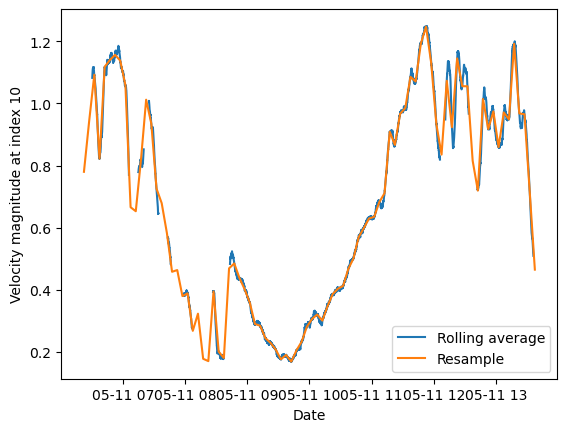

In [6]:
# Plot the outcome
fig, ax = plt.subplots()

line1, = ax.plot(ds5min.time,ds5min.magnitude[:,10])
line1.set_label('Rolling average')
line2, = ax.plot(ds5min_resample.time,ds5min_resample.magnitude[:,10])
line2.set_label('Resample')
plt.xlabel('Date')
plt.ylabel('Velocity magnitude at index 10')

plt.legend()

## 3. Now figure out what's where

In [7]:
# We've verified that the resample does what we want it to
# Now use this smaller data file for later plots
ds2 = ds5min_resample


### Make a map

Text(0, 0.5, 'Latitude')

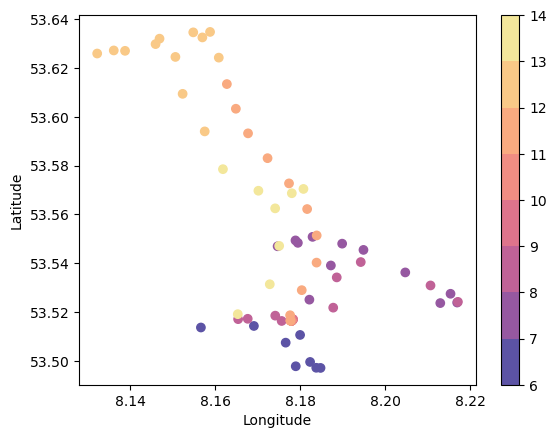

In [8]:
cmap = plt.cm.jet  # define the colormap
cmap = Sunset_7_r.mpl_colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)                               

# Hour start
tmin = mdates.date2num(ds2.time).min()
tmin = tmin-np.floor(tmin)
hourstart = np.floor(tmin*24)
# Hour end
tmax = mdates.date2num(ds2.time).max()
tmax = tmax-np.floor(tmax)
hourend = np.ceil(tmax*24)
numhours = int(hourend-hourstart+1)

hours = 24*(mdates.date2num(ds2.time)-np.floor(mdates.date2num(ds2.time).min()))

# define the bins and normalize
bounds = np.linspace(hourstart,hourend,numhours)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

# Make a figure showing the location (lat/lon) and the hour when the ship was there (colour)
plt.scatter(ds2.longitude,ds2.latitude,c=hours,cmap=cmap,norm=norm)
cb=plt.colorbar()
plt.xlabel('Longitude')
plt.ylabel('Latitude')

## Make a section (or in this case, time depth plot) of velocity

In [9]:
print(ds2.depth.shape)
print(ds2.time.shape)
print(ds2.magnitude.shape)

(140,)
(88,)
(88, 140)


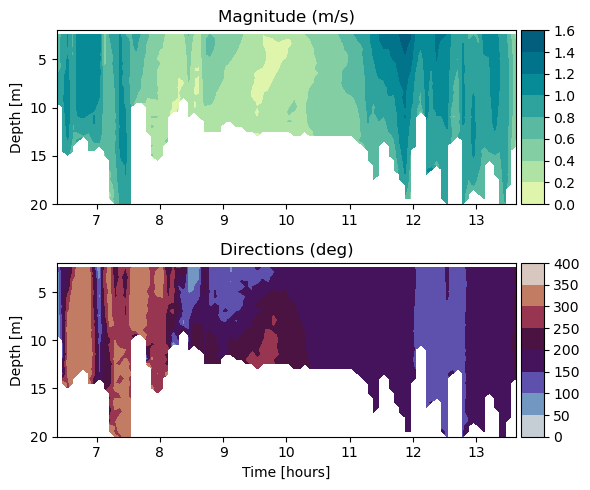

In [14]:
# Plot the magnitude against time (x) and depth (y)
fig = plt.figure(figsize=(6,5))

# Velocity magnitude
cmap = BluYl_7.mpl_colormap

# Create the upper panel with velo magnitude
ax1 = fig.add_subplot(211)
cf1 = ax1.contourf(hours,ds2.depth,ds2.magnitude.T, cmap=cmap)

# Set some annotations
ax1.set_ylim((2,20))
ax1.invert_yaxis()
ax1.set_ylabel('Depth [m]')
ax1.set_title('Magnitude (m/s)')

# Add the colorbar
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(cf1, cax=cax, orientation='vertical')


# Create the lower panel with directions
cmap = plt.cm.twilight
ax2 = fig.add_subplot(212)
cf2 = ax2.contourf(hours, ds2.depth, ds2.direction.T, cmap=cmap);
ax2.set_title('Directions (deg)')

# Add the colorbar
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(cf2, cax=cax, orientation='vertical');

# Set annotations
ax2.set_xlabel('Time [hours]')
ax2.set_ylim((2,20))
ax2.invert_yaxis()
ax2.set_ylabel('Depth [m]')

# Fix the spacing
fig.tight_layout()

fig.savefig('figures/adcp_section.png')

## 4. Where are velocities fast and slow?

Make a quiver plot of arrow vectors to see the u and v velocities.

In [26]:
# Test the transformation
#
# Note that for directions / heading, the definitions can vary.  
# You should always truth-check any transformations between eastward/northward and direction/magnitude
# This cell gives one idea for how to test the transformation.

u_range = [0,1,-1]
v_range = [1,0,-1]

for east_velocity in u_range:
    for north_velocity in v_range:

        # Calculate the magnitude
        magnitude = np.sqrt(east_velocity**2 + north_velocity**2)
        
        # Calculate the direction in radians
        direction_radians = np.arctan2(north_velocity, east_velocity)
        
        # Convert direction to degrees
        direction_degrees = np.degrees(direction_radians)
        
        # Ensure directions are in the range [0, 360)
        direction_degrees = (direction_degrees + 360) % 360
        

        # Check undoing transformation
        u_vel = magnitude*np.cos(direction_degrees*np.pi/180)
        v_vel = magnitude*np.sin(direction_degrees*np.pi/180)

        u_vel = np.round(u_vel)
        v_vel = np.round(v_vel)
        
        print('For u=' + str(east_velocity) + 'm/s and v=' + str(north_velocity) + 'm/s, the direction is ' + str(direction_degrees),' ::: Check (u,v)=('+str(u_vel)+','+str(v_vel),')')

print('---- For the example given here ---')
print('Defined this way, the directions are 0 points east, and degrees increment in the counter-clockwise direction')

For u=0m/s and v=1m/s, the direction is 90.0  ::: Check (u,v)=(0.0,1.0 )
For u=0m/s and v=0m/s, the direction is 0.0  ::: Check (u,v)=(0.0,0.0 )
For u=0m/s and v=-1m/s, the direction is 270.0  ::: Check (u,v)=(-0.0,-1.0 )
For u=1m/s and v=1m/s, the direction is 45.0  ::: Check (u,v)=(1.0,1.0 )
For u=1m/s and v=0m/s, the direction is 0.0  ::: Check (u,v)=(1.0,0.0 )
For u=1m/s and v=-1m/s, the direction is 315.0  ::: Check (u,v)=(1.0,-1.0 )
For u=-1m/s and v=1m/s, the direction is 135.0  ::: Check (u,v)=(-1.0,1.0 )
For u=-1m/s and v=0m/s, the direction is 180.0  ::: Check (u,v)=(-1.0,0.0 )
For u=-1m/s and v=-1m/s, the direction is 225.0  ::: Check (u,v)=(-1.0,-1.0 )
---- For the example given here ---
Defined this way, the directions are 0 points east, and degrees increment in the counter-clockwise direction


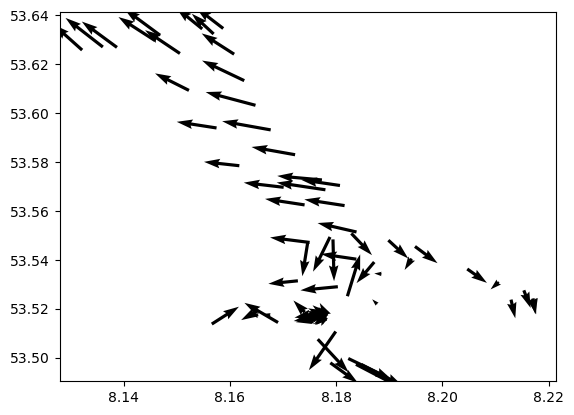

In [27]:
# Make a quiver plot
#https://stackoverflow.com/questions/19576495/color-matplotlib-quiver-field-according-to-magnitude-and-direction

u_velo = ds2.magnitude*np.cos(ds2.direction*np.pi/180)
v_velo = ds2.magnitude*np.sin(ds2.direction*np.pi/180)
#for ii in range(20,30):
for ii in range(10,11):
    x_dir1 = u_velo[:,ii]
    y_dir1 = v_velo[:,ii]
    plt.quiver(ds2.longitude, ds2.latitude, x_dir1, y_dir1)


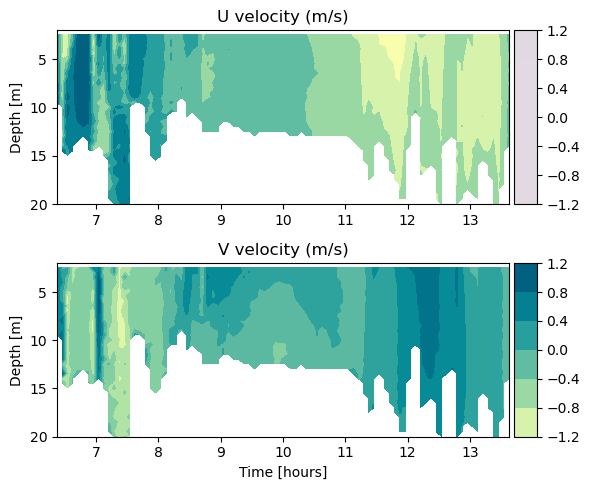

In [28]:
from matplotlib.cm import ScalarMappable

# Set some color axis limits, based on the data
vmin = -1.2
vmax = 1.2
levels=6
level_boundaries = np.linspace(vmin, vmax, levels + 1)

# Choose a colormap
cmap = BluYl_7.mpl_colormap

# Create the figure
fig = plt.figure(figsize=(6,5))

# Upper panel for U-velocity
ax1 = fig.add_subplot(211)

# Contour the data
cf1 = ax1.contourf(hours,ds2.depth,u_velo.T,cmap=cmap,
                  vmin=vmin, vmax=vmax)

# Set some annotations
ax1.set_ylim((2,20))
ax1.invert_yaxis()
ax1.set_ylabel('Depth [m]')
ax1.set_title('U velocity (m/s)')

# Add the colorbar 
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)

# Specify color limits
fig.colorbar(ScalarMappable(norm=cf2.norm, cmap=cf2.cmap),
                  cax=cax,
                  orientation='vertical',
                  boundaries=level_boundaries,
                  values=(level_boundaries[:-1] + level_boundaries[1:]) / 2,
                 )

#
# Lower panel for V-velocity
ax2 = fig.add_subplot(212)

# Contour the data
cf2 = ax2.contourf(hours,ds2.depth,v_velo.T,
                   cmap=cmap,
                   vmin=vmin, vmax=vmax
                  )

# Set some annotations
ax2.set_title('V velocity (m/s)')
ax2.set_xlabel('Time [hours]')
ax2.set_ylim((2,20))
ax2.invert_yaxis()
ax2.set_ylabel('Depth [m]')

# Add the colorbar
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)

# Specify color limits
cb = fig.colorbar(ScalarMappable(norm=cf2.norm, cmap=cf2.cmap),
                  cax=cax,
                  orientation='vertical',
                  boundaries=level_boundaries,
                  values=(level_boundaries[:-1] + level_boundaries[1:]) / 2,
                 )

# Fix the spacing between subplots
fig.tight_layout()

fig.savefig('figures/adcp_UVsxn.png')